# Pose Unposed Cameras

In [1]:
# load environment

# Load Cameras

import os
import sys
import numpy as np
import json

sys.path.append('..')
from configs.arguments import get_config_dict
from utils.multiview_utils import Camera, Calibration, MultiviewVids
from utils.io_utils import write_json, load_json
from utils.metadata_utils import get_cam_names
from utils.coordinate_utils import update_reconstruction, point_in_polygon, project_to_ground_plane_cv2
from utils.plot_utils import rotation_matrix, perp

from scipy.spatial.transform import Rotation as R
from skspatial.objects import Point, Vector, Plane, Points, Line
import pyransac3d as pyrsc

import copy
import cv2
import ipywidgets as widgets
from PIL import Image
import ipympl
import matplotlib.pyplot as plt
%matplotlib widget




arv_copy = sys.argv
sys.argv = ['pop']
sys.argv.append('-cfg')
config_path = os.path.abspath('../../project_config.yaml')
sys.argv.append(config_path)
sys.argv.append('-dr')
root_path = os.path.abspath('../../data/')
sys.argv.append(root_path)
sys.argv.append('-l')
sys.argv.append('info')

# load arguments from the arg parser
config = get_config_dict()
data_root = config["main"]["data_root"]
calib_dir = os.path.join(data_root, '0-calibration', 'calibs')
video_dir = os.path.join(data_root, 'raw_data', 'footage')
# reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'reconstruction.json')
# omni_tag = '360'


# reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction.json')
# if not os.path.exists(reconstruction_dir):
#     print( "Reconstruction not found. Please run 0-calibration/2-extrinsics.py first.")
    

13:54:51.364 - [...calibration/../configs/arguments.py:093] - DEBUG    - No training config file specified, using default config in data_root/2-training/train_config.yaml


## Select interval to examine


In [2]:
# # load interval json
# interval_json = os.path.join(data_root, '0-calibration', 'calibs', 'interval.json')

# # select_interval 
# interval_idx = 0
# interval_json = load_json(interval_json)
# interval = interval_json[interval_json.keys()[interval_idx]]

# # load cameras
# cam_names = interval['cameras']

# # load interval reconstruction
# reconstruction = load_json(reconstruction_dir / interval_json.keys()[interval_idx])

# # load calibrated cameras
# calibrated_cameras = {}
# for cam_name in cam_names:
#     calib_path = os.path.join(calib_dir, cam_name + '.json')
#     calib = load_json(calib_path)
#     calibrated_cameras[cam_name] = calib


# # load unposed cameras
# unposed_cameras = {}
# for cam_name in cam_names:
#     if cam_name not in reconstruction['cameras']:
#         unposed_cameras[cam_name] = calibrated_cameras[cam_name]

In [3]:
# dropdown for selecting the interval


intervals = os.listdir(os.path.join(data_root, '0-calibration'))

interval_dropdown = widgets.Dropdown(
    options=intervals,
    description='Interval:',
    disabled=False,
    value='opensfm'
)



display(interval_dropdown)

def update(*args):
    global posed_cameras, unposed_cameras, images
    # load calibrated cameras
    posed_cameras = []
    unposed_cameras = []
    images = {}
    # print(interval_dropdown.value)

    interval = interval_dropdown.value

    
    reconstruction_path = os.path.join(data_root, '0-calibration', interval, 'reconstruction.json')

    images_path = os.path.join(data_root, '0-calibration', interval, 'images')

    undistorted_images_path = os.path.join(data_root, '0-calibration', interval, 'undistorted', 'images')

    if not os.path.exists(reconstruction_path):
        print( "Reconstruction not found. Please run 0-calibration/2-extrinsics.py for this interval first.")
        return
    reconstruction = load_json(reconstruction_path)[0]

    cam_names = reconstruction['cameras'].keys()

    
    for cam_name in cam_names:
        try:
            camera_name = cam_name.split(' ')[1]
        except:
            camera_name = cam_name.split('_')[0]

        images[camera_name] = []

        # print(camera_name, reconstruction['shots'].keys())
        for shot in reconstruction['shots'].keys():
            if camera_name + '_' in shot:
                posed_cameras.append(camera_name)
                # posed_images[camera_name] = []
                break

        if camera_name not in posed_cameras:
            unposed_cameras.append(camera_name)
            # unposed_images[camera_name] = []

    if len(unposed_cameras) == 0:
        print('All cameras for this interval are posed already.')

    else:
        print('Unposed cameras for this interval:', unposed_cameras)
        

    for image in os.listdir(undistorted_images_path):
        for camera in images.keys():
            if camera + '_' in image:
                images[camera].append(Image.open(os.path.join(undistorted_images_path, image)))
    for image in os.listdir(images_path):
        for camera in images.keys():
            if camera in unposed_cameras and camera + '_' in image:
                images[camera].append(Image.open(os.path.join(images_path, image)))



interval_dropdown.observe(update, 'value')

update()



Dropdown(description='Interval:', index=5, options=('.DS_Store', 'calibs', 'frames', 'opensfm_old', 'opensfm.z…

Unposed cameras for this interval: ['cam3']


## Annotate Matched Keypoints

Select(description='Unposed Cameras', options=('cam3',), value='cam3')

Select(description='Posed Cameras', options=('cam360', 'cam2', 'cam1'), value='cam360')

Output()

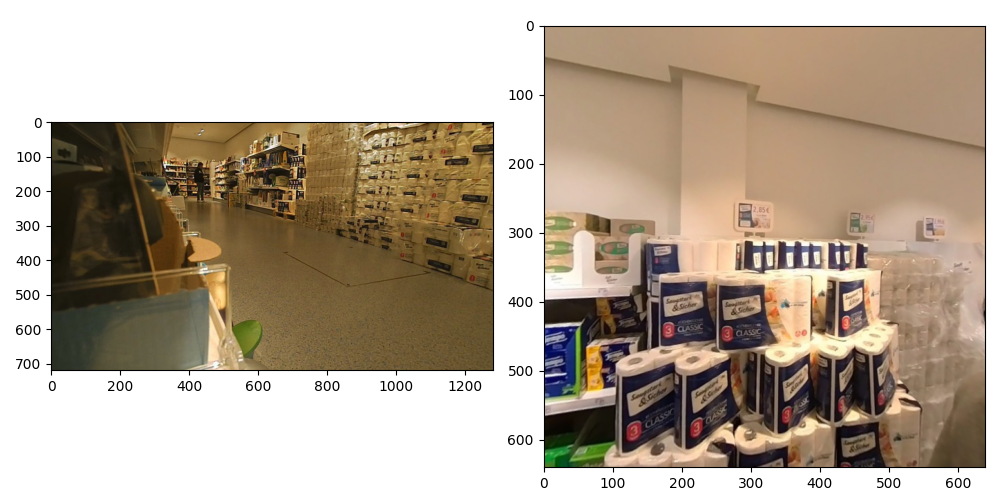

In [9]:
from IPython.display import display, clear_output

unposed_selector = widgets.Select(
    options=unposed_cameras,
    value=unposed_cameras[0],
    description='Unposed Cameras',
    disabled=False
)

posed_selector = widgets.Select(
    options=posed_cameras,
    value=posed_cameras[0],
    description='Posed Cameras',
    disabled=False
)

unposed_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Unposed Image:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
posed_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Posed Image:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(unposed_selector)
display(posed_selector)

# Create an Output widget for the sliders
slider_output = widgets.Output()

posed_images = []
unposed_images = []

fig, axs = plt.subplots(1, 2, figsize=(10, 5))


def set_img_sliders(*args):
    # clear previous sliders
    # Create an Output widget for the sliders
    slider_output.clear_output(wait=True)

    # update sliders with new values
    unposed_slider.max = len(images[unposed_selector.value]) - 1
    posed_slider.max = len(images[posed_selector.value]) - 1

    # load the images
    with slider_output:
        display(unposed_slider)
        display(posed_slider)


def render(*args):
    # print(unposed_selector.value, posed_selector.value)
    axs[0].imshow(images[unposed_selector.value][unposed_slider.value])
    axs[1].imshow(images[posed_selector.value][posed_slider.value])


display(slider_output)

unposed_selector.observe(render, 'value')
posed_selector.observe(render, 'value')
interval_dropdown.observe(render, 'value')
posed_slider.observe(render, 'value')
unposed_slider.observe(render, 'value')

posed_selector.observe(set_img_sliders, 'value')
unposed_selector.observe(set_img_sliders, 'value')

set_img_sliders()
render()

# set tight layout
plt.tight_layout()


# image_names = os.listdir(os.path.join(data_root, '0-calibration', interval_dropdown.value, 'images'))

# for image_name in image_names:
#     if image_name.split('_')[0] in unposed_cameras:
#         unposed_cameras[image_name.split('_')[0]].add_image(image_name)
#     else:
#         posed_cameras[image_name.split('_')[0]].add_image(image_name)
